### Filtering Alerts

Here are some examples of filtering alerts based on the packet contents.

In [14]:
import os
import io
import gzip
import tarfile
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter
import fastavro

from astropy.time import Time
from astropy.io import fits
import astropy.units as u
import aplpy
%matplotlib inline

Tar archives of ZTF alerts are available from https://ztf.uw.edu/public/alerts.  Let's extract to a directory:

In [19]:
DATA_DIR = '~/Downloads/ztf_public_20201106/'

Let's count packets.

In [20]:
def find_files(root_dir):
    for dir_name, subdir_list, file_list in os.walk(os.path.expanduser(root_dir), followlinks=True):
        for fname in file_list:
            if fname.endswith('.avro'):
                yield dir_name+'/'+fname

In [21]:
print('{} has {} avro files'.format(DATA_DIR, len(list(find_files(DATA_DIR)))))

~/Downloads/ztf_public_20201106/ has 41374 avro files


In [22]:
def open_avro(fname):
    with open(fname,'rb') as f:
        freader = fastavro.reader(f)
        # in principle there can be multiple packets per file
        for packet in freader:
            yield packet

In [23]:
def generate_dictionaries(root_dir):
    for fname in find_files(root_dir):
        for packet in open_avro(fname):
            yield packet

Let's count the number of observations by program (should all be public!).  Reviewing the [alert packet contents](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html), we want the `programid` field in `candidate`.

In [24]:
%%time
from collections import defaultdict
programs = defaultdict(int)
for packet in generate_dictionaries(DATA_DIR):
    programs[packet['candidate']['programid']] += 1
print(programs)

defaultdict(<class 'int'>, {1: 41374})
CPU times: user 43.1 s, sys: 1.7 s, total: 44.8 s
Wall time: 46.7 s


The alert archive is a fairly raw stream.  Users desiring greater purity can apply the [suggested filters](https://zwickytransientfacility.github.io/ztf-avro-alert/filtering.html):

```
rb >= 0.65 and
nbad = 0 and
fwhm <= 5 and
elong <= 1.2 and
abs(magdiff) <= 0.1
```

In [25]:
def is_alert_pure(packet):
    pure = True
    pure &= packet['candidate']['rb'] >= 0.65
    pure &= packet['candidate']['nbad'] == 0
    pure &= packet['candidate']['fwhm'] <= 5
    pure &= packet['candidate']['elong'] <= 1.2
    pure &= np.abs(packet['candidate']['magdiff']) <= 0.1
    return pure

Let's count the purified packets:

In [26]:
%%time
programs = defaultdict(int)
for packet in filter(is_alert_pure,generate_dictionaries(DATA_DIR)):
    programs[packet['candidate']['programid']] += 1
print(programs)

defaultdict(<class 'int'>, {1: 8801})
CPU times: user 42.4 s, sys: 1.11 s, total: 43.5 s
Wall time: 44.6 s


For applications using lightcurves it's useful to have the data in a dataframe, but this construction is somewhat slower, so let's apply it after our initial filter.

In [27]:
def make_dataframe(packet):
    dfc = pd.DataFrame(packet['candidate'], index=[0])
    df_prv = pd.DataFrame(packet['prv_candidates'])
    dflc = pd.concat([dfc,df_prv], ignore_index=True)
    # we'll attach some metadata--not this may not be preserved after all operations
    # https://stackoverflow.com/questions/14688306/adding-meta-information-metadata-to-pandas-dataframe
    dflc.objectId = packet['objectId']
    dflc.candid = packet['candid']
    return dflc

Let's use the following cuts to select likely extragalactic transients:

* the difference image detection should be positive
* if there is a PS1 source within 1.5" of the source, it should have a star-galaxy score of < 0.5 (galaxy-like)
* there should be at least two detections separated by more than 30 minutes
* there should be no known solar system object within 5"

In [28]:
def is_transient(dflc):
    
    candidate = dflc.loc[0]
    
    is_positive_sub = candidate['isdiffpos'] == 't'
    
    if (candidate['distpsnr1'] is None) or (candidate['distpsnr1'] > 1.5):
        no_pointsource_counterpart = True
    else:
        if candidate['sgscore1'] < 0.5:
            no_pointsource_counterpart = True
        else:
            no_pointsource_counterpart = False
            
    where_detected = (dflc['isdiffpos'] == 't') # nondetections will be None
    if np.sum(where_detected) >= 2:
        detection_times = dflc.loc[where_detected,'jd'].values
        dt = np.diff(detection_times)
        not_moving = np.max(dt) >= (30*u.minute).to(u.day).value
    else:
        not_moving = False
    
    no_ssobject = (candidate['ssdistnr'] is None) or (candidate['ssdistnr'] < 0) or (candidate['ssdistnr'] > 5)
    
    return is_positive_sub and no_pointsource_counterpart and not_moving and no_ssobject

In [29]:
%%time
transient_alerts = []
for packet in filter(is_alert_pure,generate_dictionaries(DATA_DIR)):
    dflc = make_dataframe(packet)
    if is_transient(dflc):
        print(packet['objectId'])
        transient_alerts.append(packet)

ZTF18acvhqfj
ZTF18aczdxge
ZTF20acpbbqf
ZTF18acbzqko
ZTF20aclnpgu
ZTF20ackhoov
ZTF18achyrew
ZTF20acpeuak
ZTF19acokejo
ZTF19aapdwqc
ZTF18aabxczq
ZTF20abywpje
ZTF20acjhyto
ZTF20acnzkxb
ZTF18aajjhpc
ZTF20aciuubo
ZTF18aakddkj
ZTF19aamgqia
ZTF20acfasbq
ZTF20acimsnl
ZTF18aaepdxd
ZTF20achoqvb
ZTF20aaawwkl
ZTF18adayxxz
ZTF18acwwkyl
ZTF20acmfacr
ZTF18aaddhpb
ZTF20acmvzuo
ZTF20acfasbq
ZTF20aaskeca
ZTF20acnykjt
ZTF18acbwadi
ZTF19aadkzep
ZTF17aaapeac
ZTF19aampokl
ZTF18absltuj
ZTF18acewnwv
ZTF20aacbwbm
ZTF18aaeisel
ZTF20acgoxns
ZTF18abuqhmh
ZTF19aangopc
ZTF20ackrzta
ZTF19aaerbpg
ZTF18acqyzsc
ZTF20acjryhf
ZTF19aaabvzh
ZTF20ackijaj
ZTF20acpgmga
ZTF19abzzylo
ZTF20acoxmsr
ZTF20acotwur
ZTF19acqdoxv
ZTF18acrvpkf
ZTF18aajlyzn
ZTF20abnorit
ZTF18aahrzkb
ZTF19aarsrls
ZTF18aahfhsm
ZTF20aclgnds
ZTF20abqvsik
ZTF20abyyvrw
ZTF20acjhyto
ZTF20acokohj
ZTF20acogywb
ZTF20acpeuak
ZTF19acokqnb
ZTF20acmewfw
ZTF20abgvily
ZTF18aaddhpb
ZTF18aayajbe
ZTF18acdvzyr
ZTF20acoxmsr
ZTF19acccyyt
ZTF18acwwkyl
ZTF20aadavga
ZTF20acivqxn

KeyboardInterrupt: 

Now let's do the same thing and make plots instead:

In [30]:
def plot_lightcurve(dflc, ax=None, days_ago=True):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    if ax is None:
        plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'magpsf'], dflc.loc[w,'sigmapsf'],fmt='.',color=color)
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.sum(wnodet):
            plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    plt.title(dflc.objectId)
    

In [35]:
def plot_cutout(stamp, fig=None, subplot=None, **kwargs):
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            if fig is None:
                fig = plt.figure(figsize=(4,4))
            if subplot is None:
                subplot = (1,1,1)
            ffig = aplpy.FITSFigure(hdul[0],figure=fig, subplot=subplot, **kwargs)
            ffig.show_grayscale(stretch='power')
    return ffig

Now let's make a nice helper function:

In [36]:
def show_stamps(packet):
    #fig, axes = plt.subplots(1,3, figsize=(12,4))
    fig = plt.figure(figsize=(12,4))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(cutout)

In [37]:
def show_all(packet):
    fig = plt.figure(figsize=(16,4))
    dflc = make_dataframe(packet)
    plot_lightcurve(dflc,ax = plt.subplot(1,4,1))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)]['stampData']
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,4,i+2))
        ffig.set_title(cutout)

INFO: Auto-setting vmin to  1.177e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.784e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.423e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.665e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.077e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.530e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.139e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.343e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.418e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.052e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.166e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.495e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.748e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.389e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.985e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.295e+03 [aplpy.core]


INFO: Auto-setting vmin to -3.122e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.254e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.456e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.533e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.684e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.311e+03 [aplpy.core]


INFO: Auto-setting vmin to -1.632e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.550e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.530e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.378e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.772e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.219e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.749e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.400e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.809e+02 [aplpy.core]
INFO: Auto-setting vmax to  9.998e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.050e+02 [aplpy.core]
INFO: Auto-setting vmax to  9.326e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.136e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.524e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.640e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.920e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.680e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.427e+03 [aplpy.core]


INFO: Auto-setting vmin to -9.753e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.162e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.104e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.248e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.354e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.467e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.674e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.096e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.326e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.099e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.605e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.945e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.942e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.208e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.183e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.747e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.411e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.531e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.551e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.874e+01 [aplpy.core]


INFO: Auto-setting vmin to  8.655e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.612e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.099e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.307e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.812e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.569e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.313e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.437e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.532e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.988e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.403e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.233e+01 [aplpy.core]


INFO: Auto-setting vmin to  9.795e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.650e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.247e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.468e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.139e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.209e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.558e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.639e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.812e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.928e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.904e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.667e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.447e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.595e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.667e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.440e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.420e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.806e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.815e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.194e+03 [aplpy.core]


INFO: Auto-setting vmin to  3.067e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.852e+03 [aplpy.core]


INFO: Auto-setting vmin to -8.498e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.318e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.956e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.061e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.240e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.953e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.134e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.104e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.304e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.004e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.533e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.801e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.728e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.510e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.345e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.571e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.538e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.392e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.185e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.618e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.949e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.821e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.188e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.782e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.491e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.718e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.485e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.708e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.403e+38 [aplpy.core]
INFO: Auto-setting vmax to  2.965e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.506e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.720e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.608e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.031e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.844e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.802e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.649e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.591e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.584e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.514e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.837e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.891e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.787e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.578e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.605e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.868e+03 [aplpy.core]


INFO: Auto-setting vmin to  3.837e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.510e+03 [aplpy.core]


INFO: Auto-setting vmin to -1.427e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.594e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.002e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.231e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.274e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.183e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.925e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.460e+01 [aplpy.core]


INFO: Auto-setting vmin to  4.345e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.773e+03 [aplpy.core]


INFO: Auto-setting vmin to  4.586e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.835e+03 [aplpy.core]


INFO: Auto-setting vmin to -3.858e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.989e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.147e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.587e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.408e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.807e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.592e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.114e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.711e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.360e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.953e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.187e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.481e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.805e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.022e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.812e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.224e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.858e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.550e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.920e+01 [aplpy.core]


INFO: Auto-setting vmin to  5.539e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.512e+03 [aplpy.core]


INFO: Auto-setting vmin to  5.771e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.550e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.471e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.012e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.647e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.572e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.859e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.824e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.894e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.454e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.470e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.014e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.677e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.845e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.461e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.795e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.383e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.340e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.633e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.587e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.043e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.596e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.187e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.036e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.466e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.422e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.772e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.164e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.998e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.224e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.226e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.886e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.213e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.951e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.367e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.997e+03 [aplpy.core]


INFO: Auto-setting vmin to  2.570e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.136e+03 [aplpy.core]


INFO: Auto-setting vmin to -1.488e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.978e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.109e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.211e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.385e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.879e+03 [aplpy.core]


INFO: Auto-setting vmin to -2.928e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.824e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.745e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.559e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.022e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.463e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.911e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.969e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.414e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.162e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.691e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.052e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.843e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.165e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.480e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.792e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.712e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.753e+03 [aplpy.core]


INFO: Auto-setting vmin to -1.300e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.604e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.881e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.241e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.094e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.969e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.619e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.340e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.725e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.345e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.957e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.092e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.726e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.089e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.310e+02 [aplpy.core]
INFO: Auto-setting vmax to  9.840e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.541e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.166e+03 [aplpy.core]


INFO: Auto-setting vmin to -1.460e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.327e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.497e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.298e+03 [aplpy.core]


INFO: Auto-setting vmin to  3.731e+02 [aplpy.core]
INFO: Auto-setting vmax to  9.930e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.952e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.320e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.282e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.187e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.527e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.026e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.996e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.272e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.797e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.463e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.057e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.260e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.137e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.378e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.861e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.416e+04 [aplpy.core]


INFO: Auto-setting vmin to  2.113e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.145e+04 [aplpy.core]


INFO: Auto-setting vmin to -2.380e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.782e+02 [aplpy.core]


INFO: Auto-setting vmin to  4.012e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.835e+02 [aplpy.core]


INFO: Auto-setting vmin to  4.311e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.813e+02 [aplpy.core]


INFO: Auto-setting vmin to -4.524e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.412e+01 [aplpy.core]


INFO: Auto-setting vmin to  9.142e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.536e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.145e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.322e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.844e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.058e+01 [aplpy.core]


INFO: Auto-setting vmin to  5.976e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.781e+02 [aplpy.core]


INFO: Auto-setting vmin to  8.582e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.210e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.237e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.607e+01 [aplpy.core]


INFO: Auto-setting vmin to  4.672e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.136e+02 [aplpy.core]


INFO: Auto-setting vmin to  4.918e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.797e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.133e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.663e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.793e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.695e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.028e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.178e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.771e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.130e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.095e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.024e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.392e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.837e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.090e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.443e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.067e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.386e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.355e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.020e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.051e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.568e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.701e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.002e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.963e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.692e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.810e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.346e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.865e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.752e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.147e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.580e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.004e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.247e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.863e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.924e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.155e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.496e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.038e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.752e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.196e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.808e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.445e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.548e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.375e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.682e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.056e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.139e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.309e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.201e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.756e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.669e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.556e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.400e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.835e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.873e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.291e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.666e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.852e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.041e+03 [aplpy.core]


INFO: Auto-setting vmin to  2.053e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.006e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.963e+01 [aplpy.core]
INFO: Auto-setting vmax to  9.725e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.455e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.076e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.717e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.834e+02 [aplpy.core]


INFO: Auto-setting vmin to -5.144e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.409e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.380e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.120e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.639e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.950e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.695e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.086e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.410e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.142e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.706e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.023e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.175e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.387e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.320e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.811e+03 [aplpy.core]


INFO: Auto-setting vmin to  3.505e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.531e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.900e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.366e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.494e+02 [aplpy.core]
INFO: Auto-setting vmax to  9.599e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.710e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.130e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.811e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.319e+01 [aplpy.core]


INFO: Auto-setting vmin to  8.872e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.763e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.154e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.632e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.772e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.976e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.479e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.159e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.729e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.937e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.398e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.922e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.698e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.380e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.935e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.242e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.148e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.370e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.401e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.897e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.655e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.756e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.751e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.753e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.865e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.730e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.104e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.522e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.457e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.974e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.380e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.408e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.650e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.301e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.070e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.327e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.084e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.025e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.353e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.724e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.975e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.730e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.409e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.596e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.723e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.420e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.570e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.139e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.793e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.756e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.037e+02 [aplpy.core]
INFO: Auto-setting vmax to  5.491e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.737e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.425e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.323e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.012e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.598e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.726e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.006e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.039e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.279e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.181e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.553e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.944e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.087e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.375e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.298e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.905e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.539e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.738e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.663e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.776e+01 [aplpy.core]


INFO: Auto-setting vmin to  4.698e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.067e+03 [aplpy.core]


INFO: Auto-setting vmin to  4.925e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.034e+03 [aplpy.core]


INFO: Auto-setting vmin to -3.312e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.799e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.007e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.381e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.273e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.636e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.038e+01 [aplpy.core]
INFO: Auto-setting vmax to  8.599e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.260e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.684e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.522e+02 [aplpy.core]
INFO: Auto-setting vmax to  4.532e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.928e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.330e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.860e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.396e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.116e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.095e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.956e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.563e+01 [aplpy.core]


INFO: Auto-setting vmin to  7.270e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.439e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.001e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.201e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.943e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.299e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.915e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.752e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.141e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.536e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.589e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.864e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.239e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.606e+03 [aplpy.core]


INFO: Auto-setting vmin to  2.495e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.232e+03 [aplpy.core]


INFO: Auto-setting vmin to -5.384e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.475e+01 [aplpy.core]


INFO: Auto-setting vmin to  4.428e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.381e+02 [aplpy.core]


INFO: Auto-setting vmin to  7.251e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.108e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.964e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.633e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.740e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.532e+03 [aplpy.core]


INFO: Auto-setting vmin to  2.014e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.168e+03 [aplpy.core]


INFO: Auto-setting vmin to -8.495e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.114e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.326e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.274e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.577e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.174e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.715e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.145e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.572e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.749e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.814e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.023e+02 [aplpy.core]


INFO: Auto-setting vmin to -6.444e+01 [aplpy.core]
INFO: Auto-setting vmax to  4.697e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.068e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.540e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.283e+02 [aplpy.core]
INFO: Auto-setting vmax to  9.625e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.789e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.978e+01 [aplpy.core]


INFO: Auto-setting vmin to  6.970e+01 [aplpy.core]
INFO: Auto-setting vmax to  7.226e+02 [aplpy.core]


INFO: Auto-setting vmin to  9.427e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.029e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.110e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.710e+01 [aplpy.core]


INFO: Auto-setting vmin to  3.374e+02 [aplpy.core]
INFO: Auto-setting vmax to  8.438e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.570e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.438e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.196e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.640e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.112e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.042e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.366e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.362e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.851e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.332e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.299e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.380e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.573e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.035e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.424e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.757e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.376e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.175e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.650e+02 [aplpy.core]
INFO: Auto-setting vmax to  1.936e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.245e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.519e+01 [aplpy.core]


INFO: Auto-setting vmin to  6.376e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.078e+02 [aplpy.core]


INFO: Auto-setting vmin to  8.809e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.798e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.601e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.189e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.595e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.773e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.826e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.575e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.270e+01 [aplpy.core]
INFO: Auto-setting vmax to  3.381e+01 [aplpy.core]


INFO: Auto-setting vmin to  2.326e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.957e+02 [aplpy.core]


INFO: Auto-setting vmin to  2.541e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.200e+02 [aplpy.core]


INFO: Auto-setting vmin to -8.168e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.903e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.728e+02 [aplpy.core]
INFO: Auto-setting vmax to  7.015e+02 [aplpy.core]


INFO: Auto-setting vmin to  3.986e+02 [aplpy.core]
INFO: Auto-setting vmax to  6.585e+02 [aplpy.core]


INFO: Auto-setting vmin to -3.024e+01 [aplpy.core]
INFO: Auto-setting vmax to  5.789e+01 [aplpy.core]


INFO: Auto-setting vmin to  1.156e+02 [aplpy.core]
INFO: Auto-setting vmax to  3.717e+03 [aplpy.core]


INFO: Auto-setting vmin to  1.412e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.889e+03 [aplpy.core]


INFO: Auto-setting vmin to -4.692e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.460e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.256e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.368e+02 [aplpy.core]


INFO: Auto-setting vmin to  1.498e+02 [aplpy.core]
INFO: Auto-setting vmax to  2.246e+02 [aplpy.core]


INFO: Auto-setting vmin to -2.701e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.665e+01 [aplpy.core]


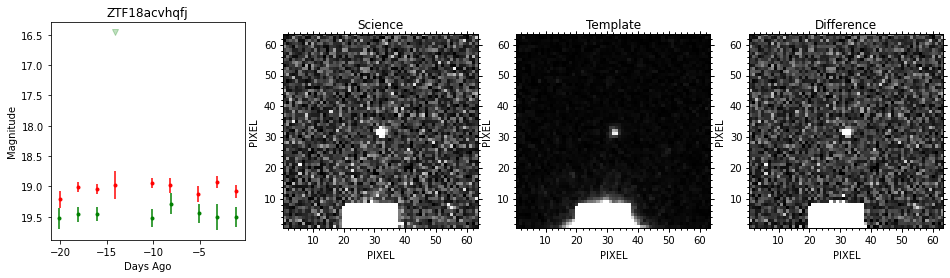

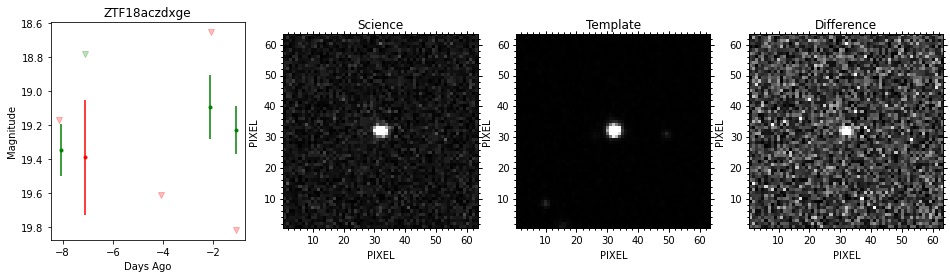

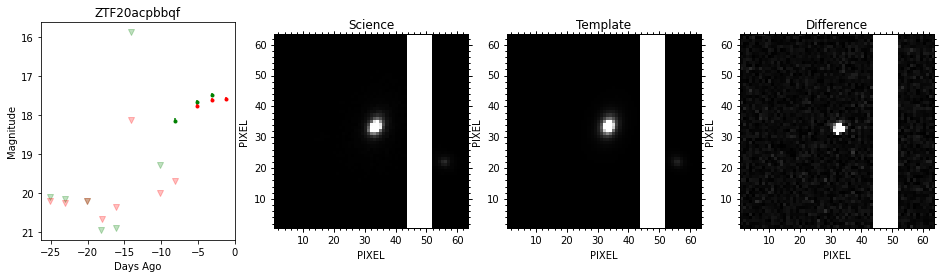

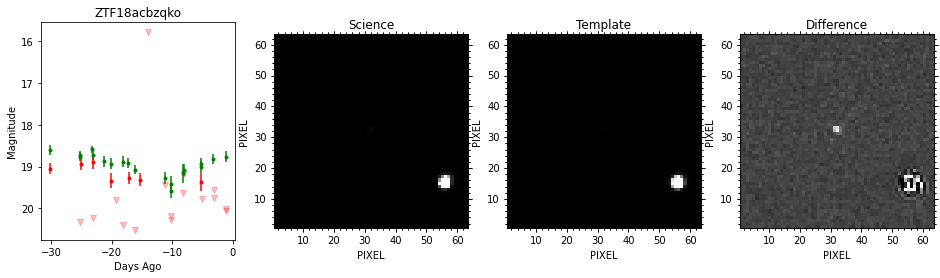

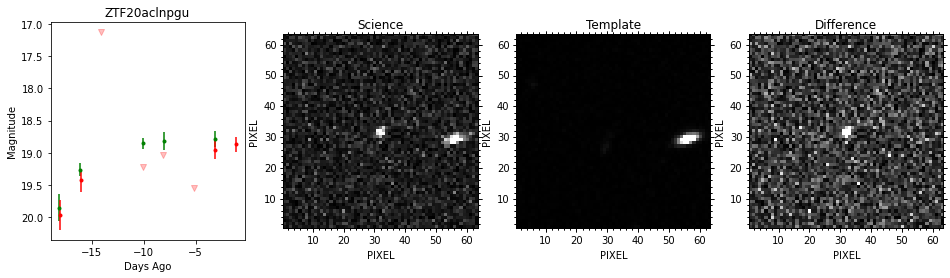

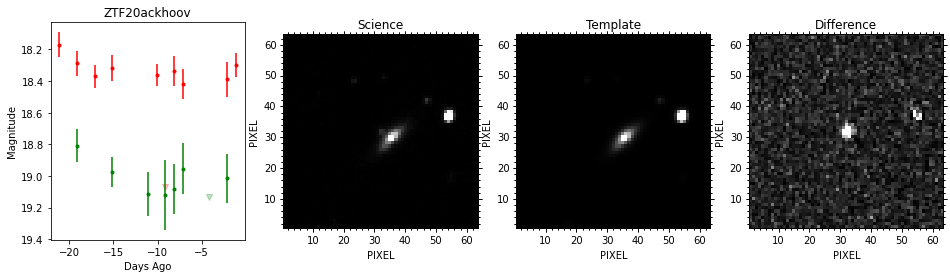

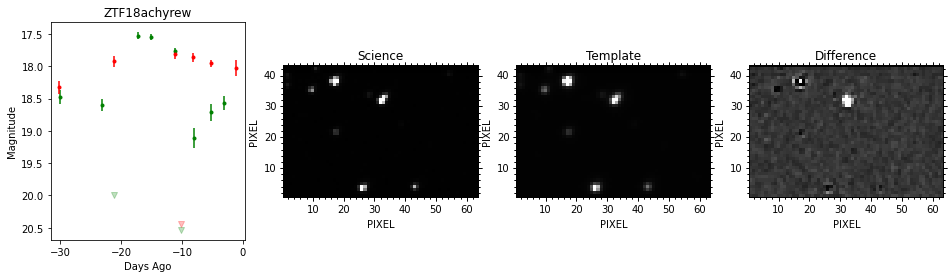

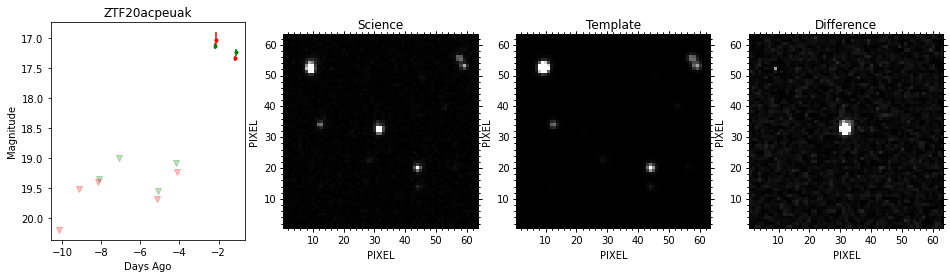

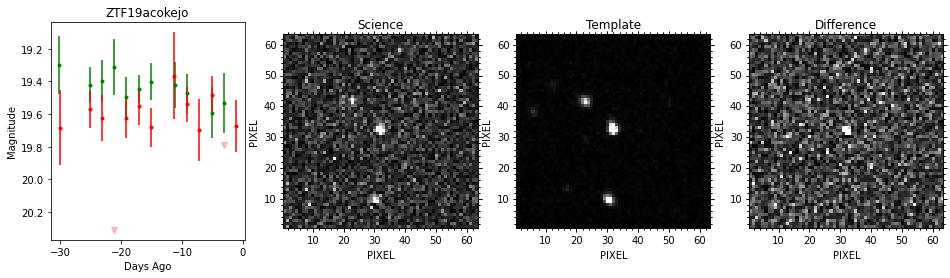

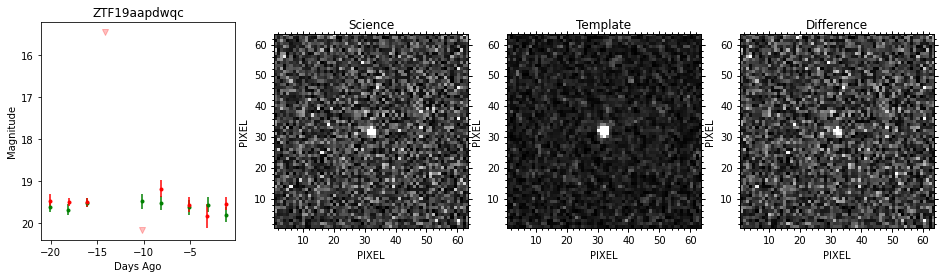

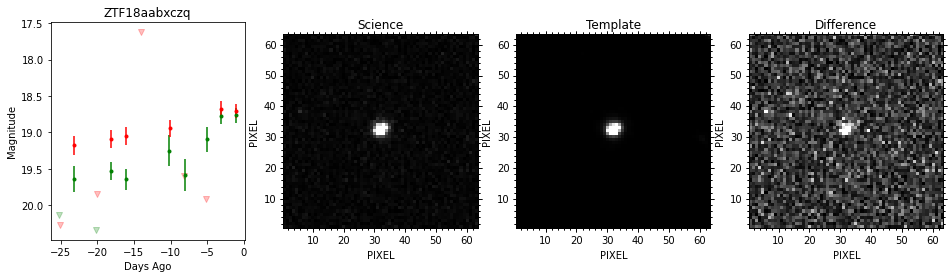

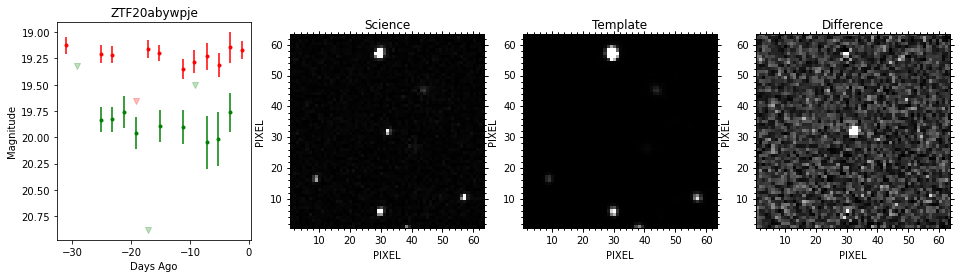

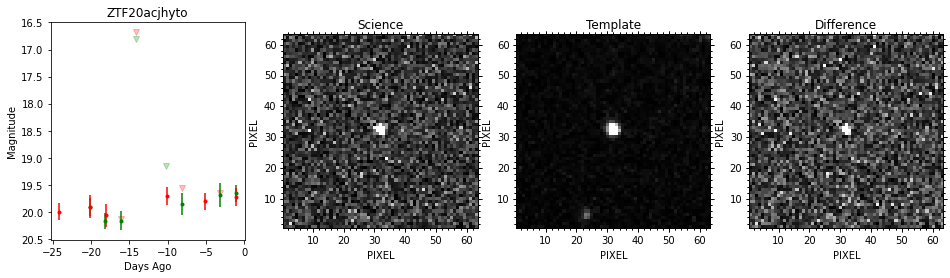

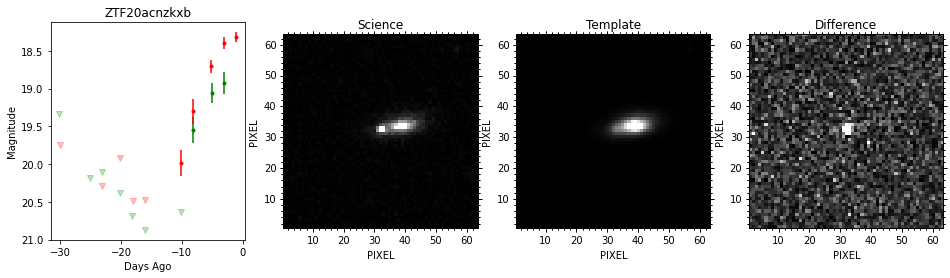

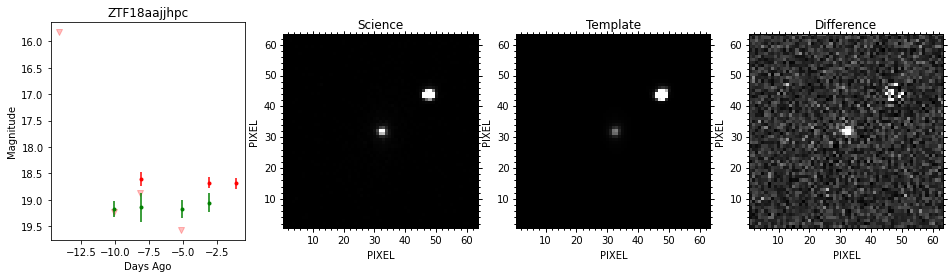

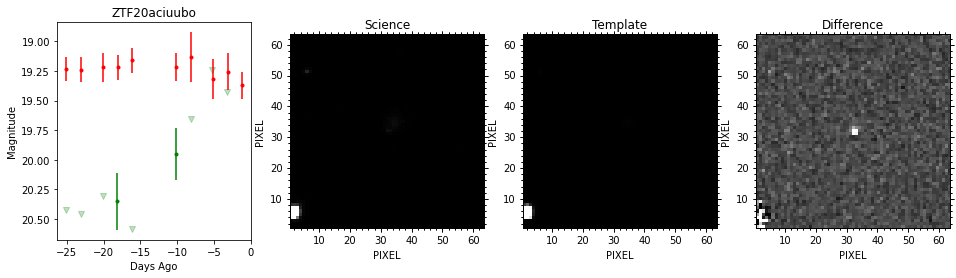

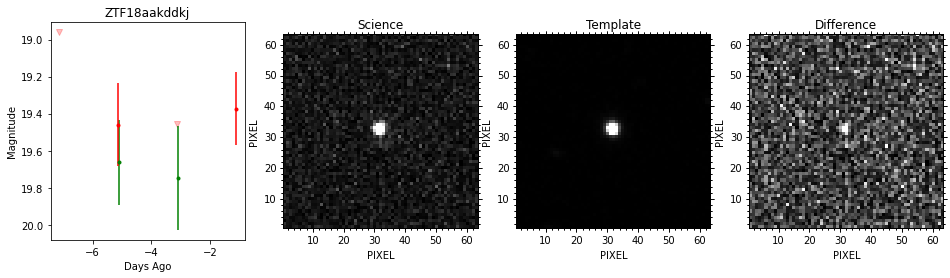

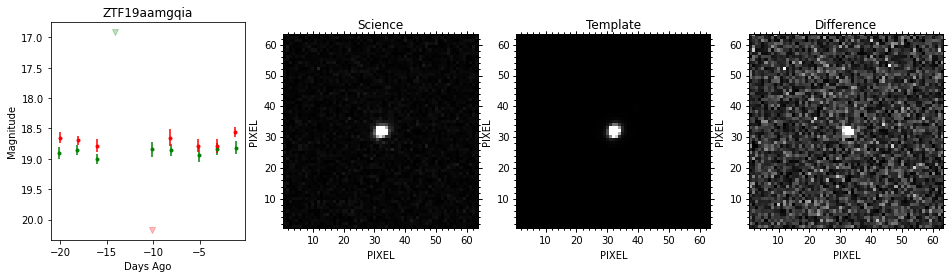

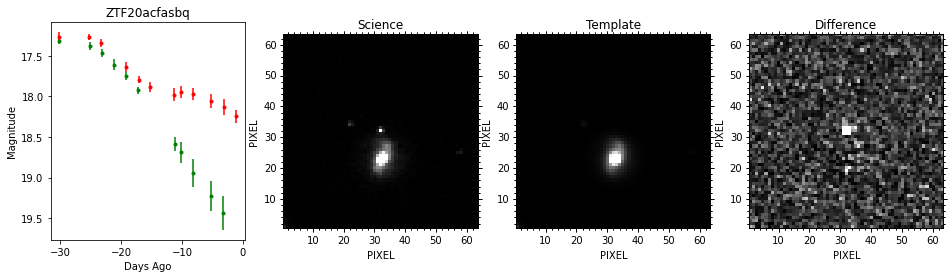

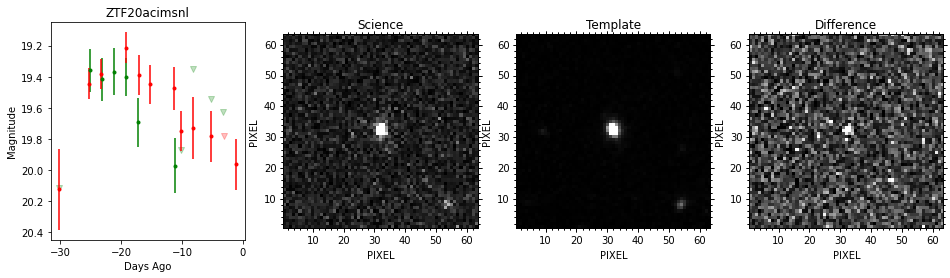

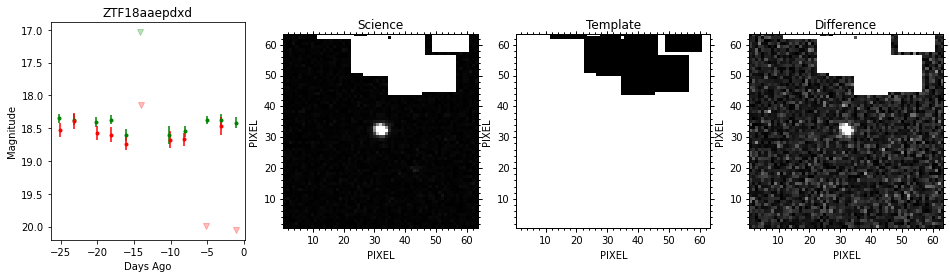

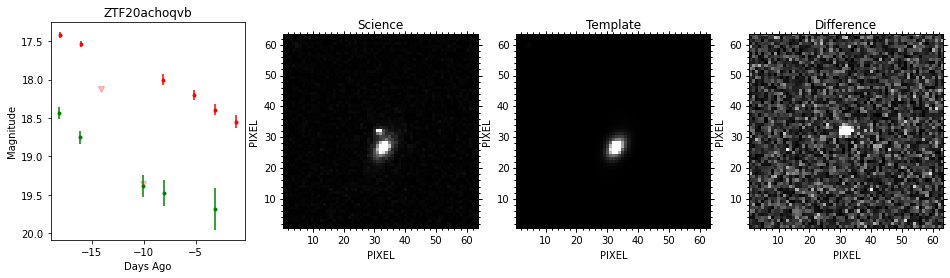

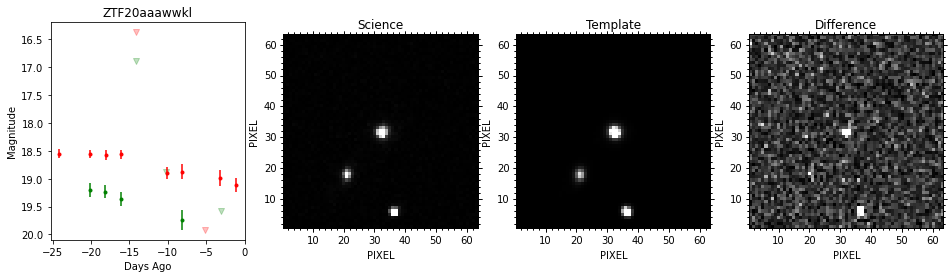

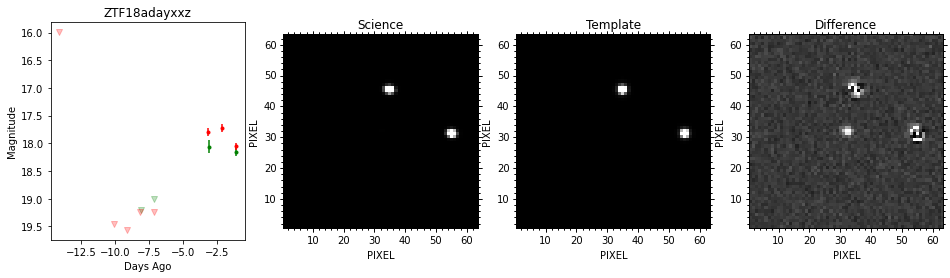

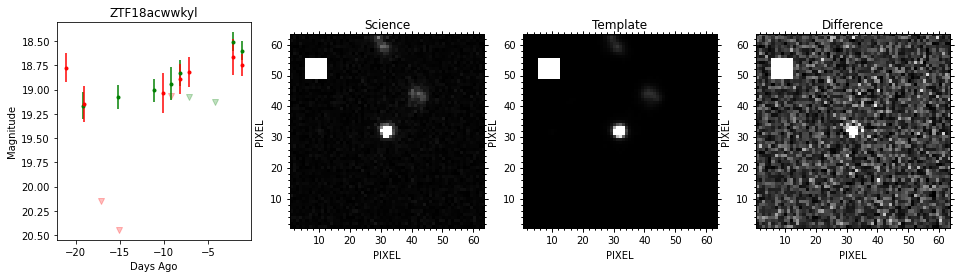

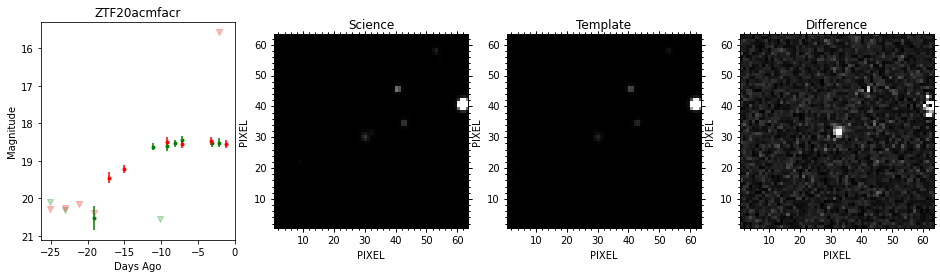

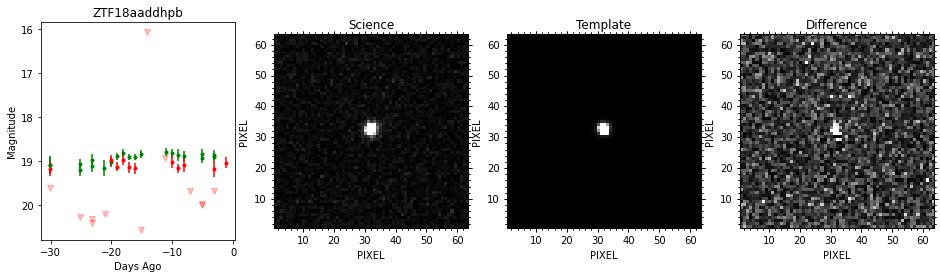

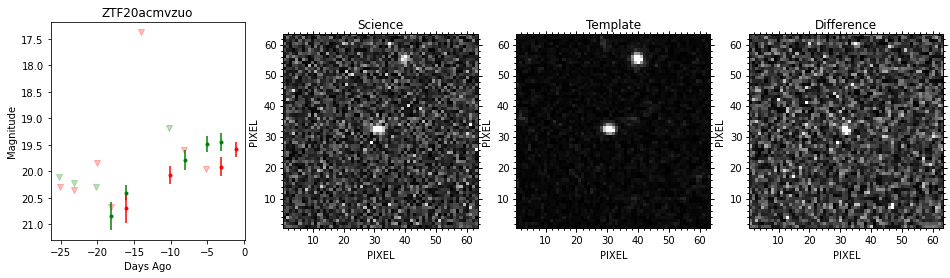

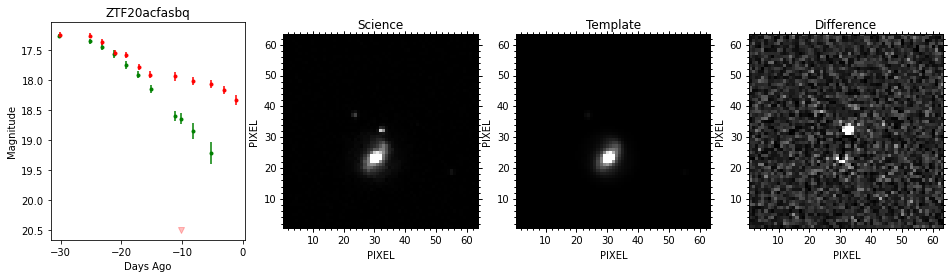

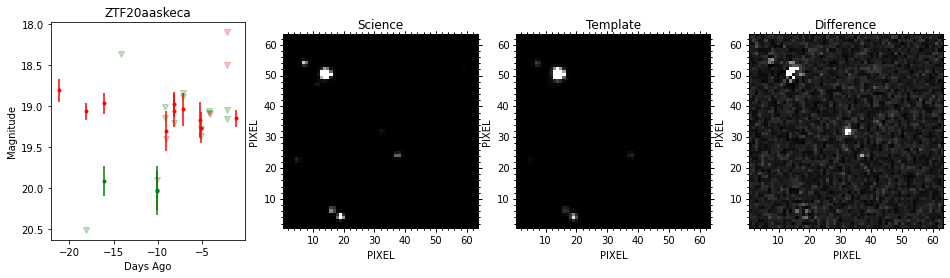

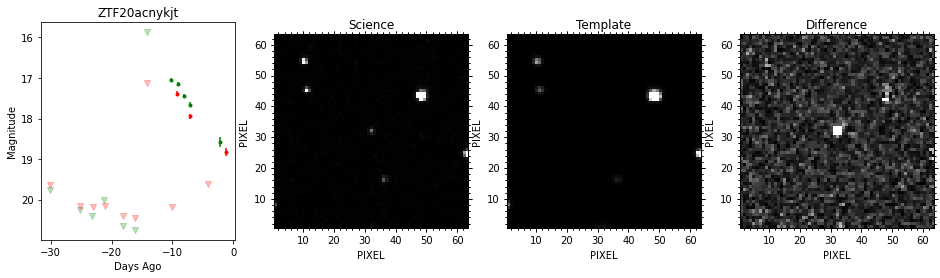

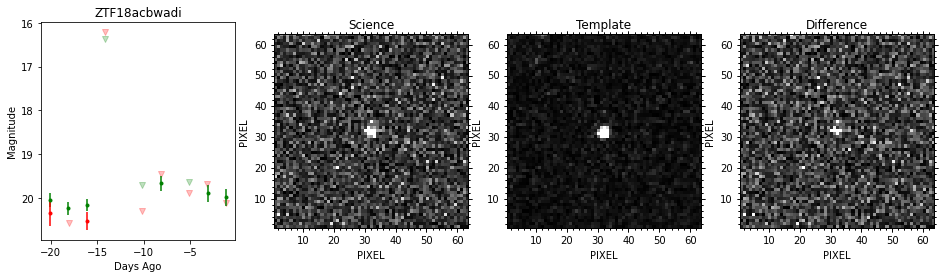

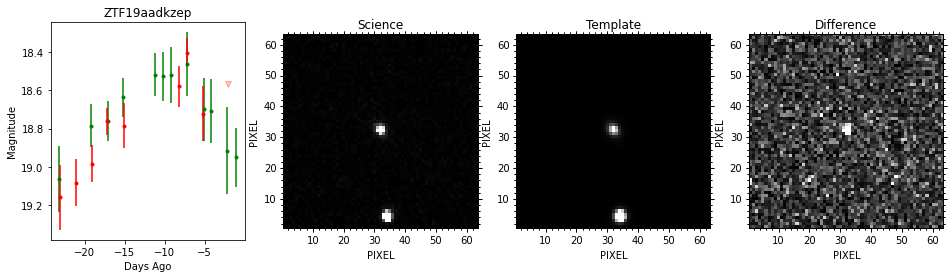

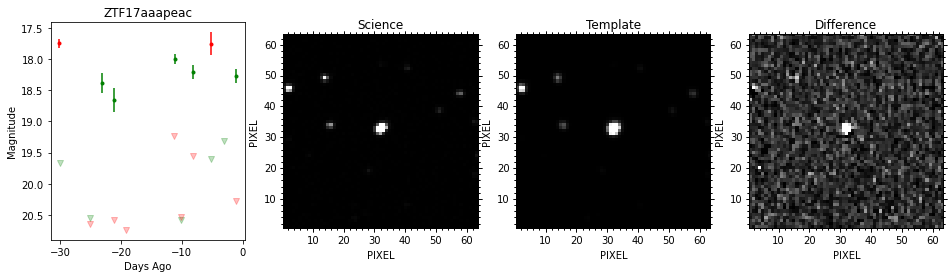

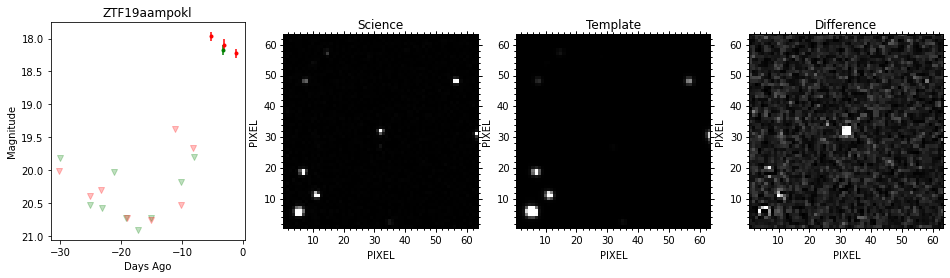

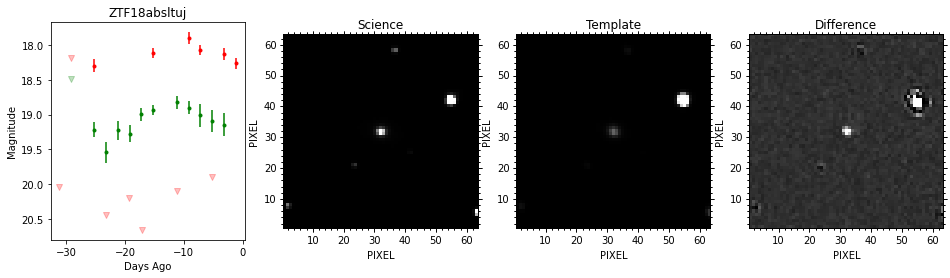

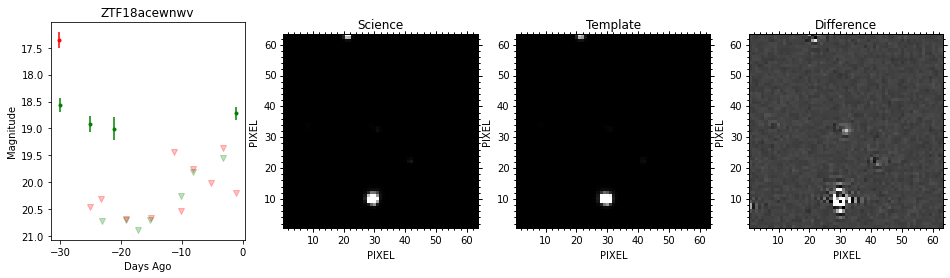

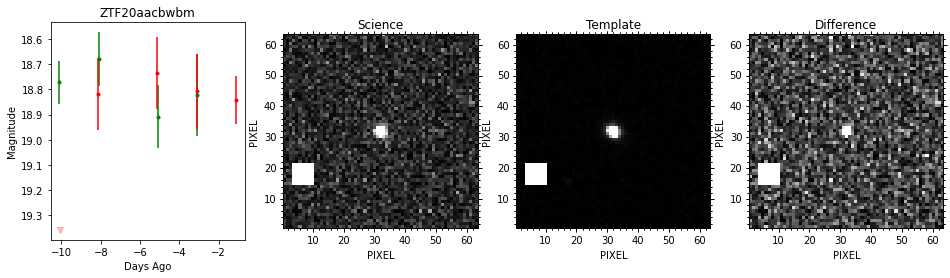

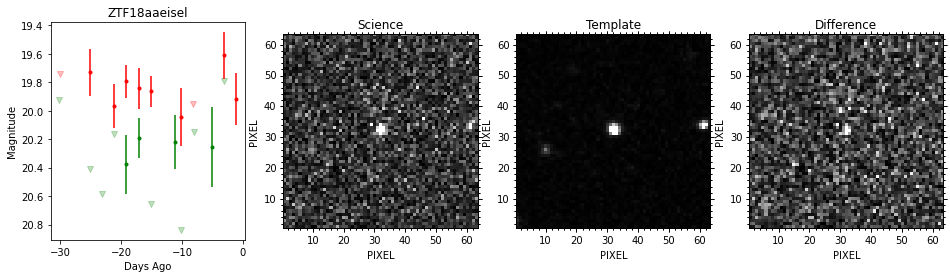

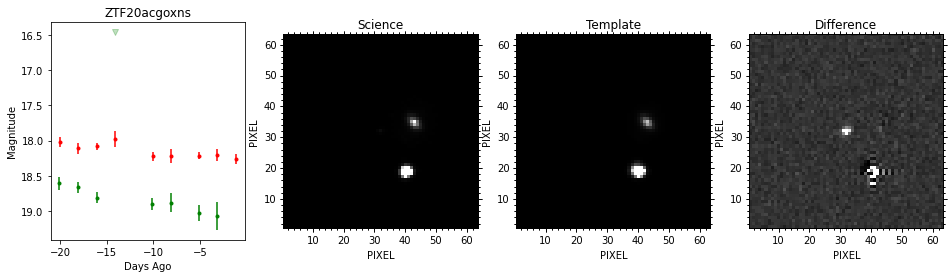

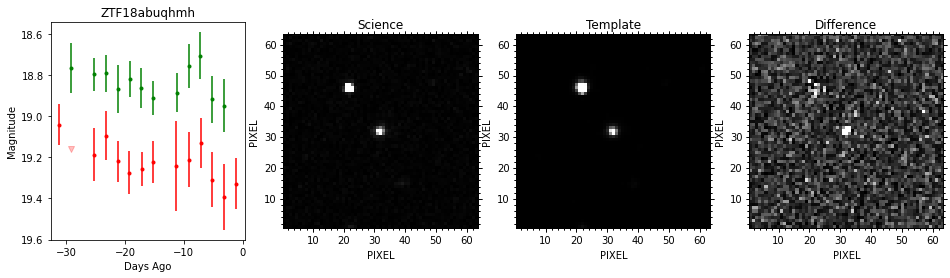

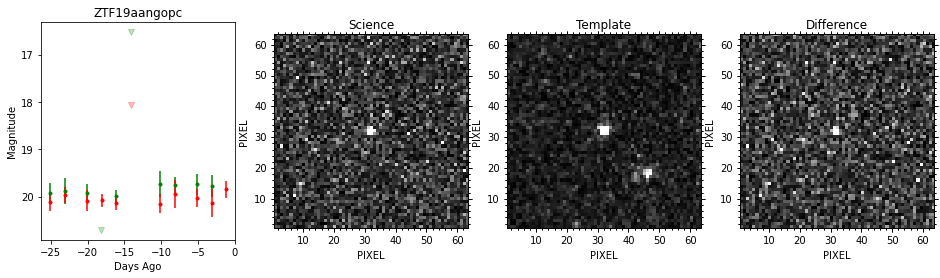

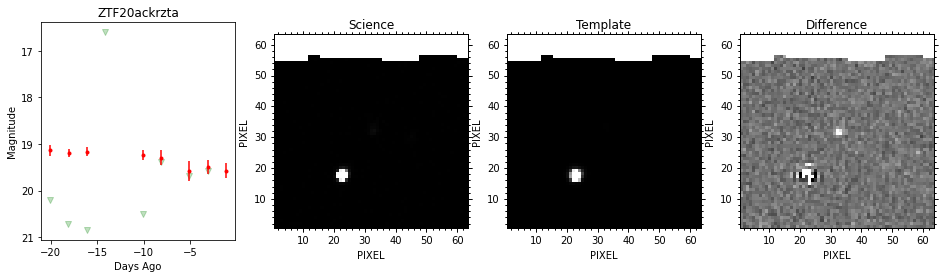

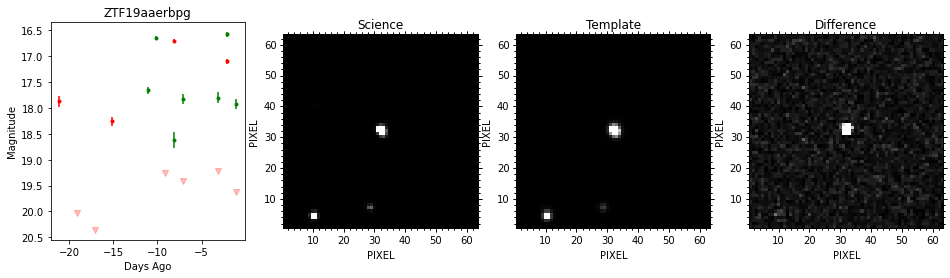

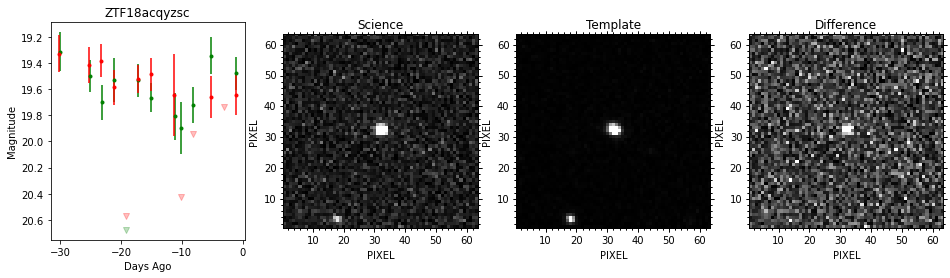

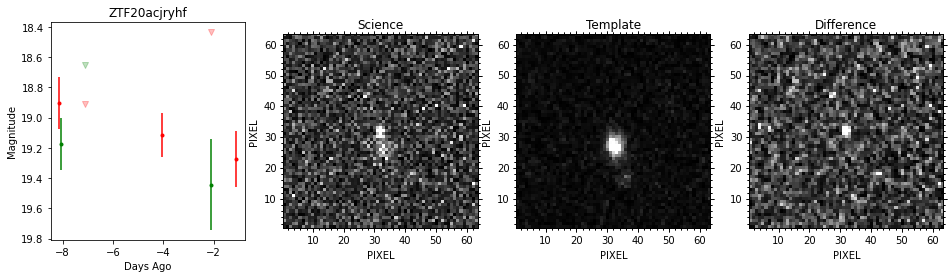

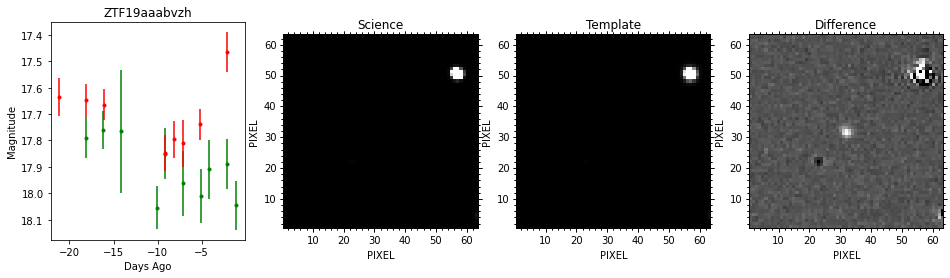

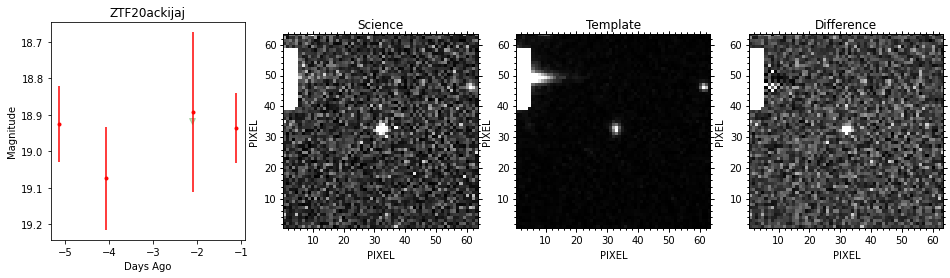

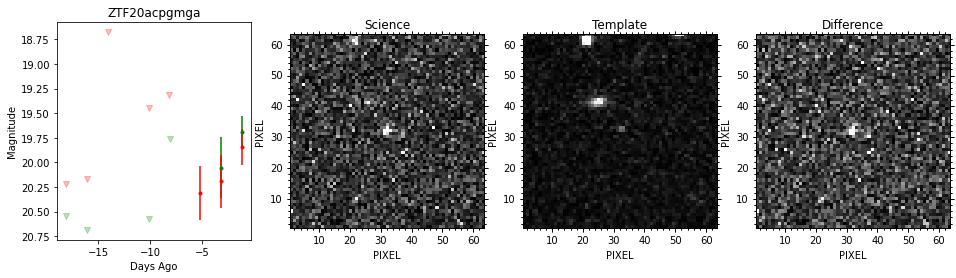

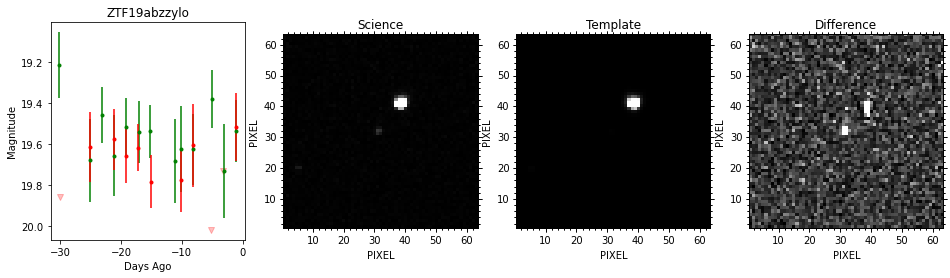

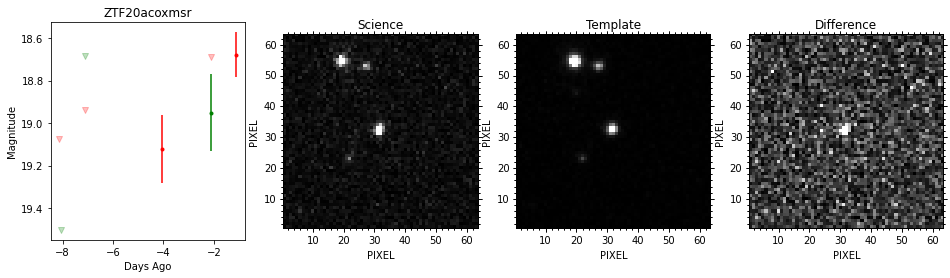

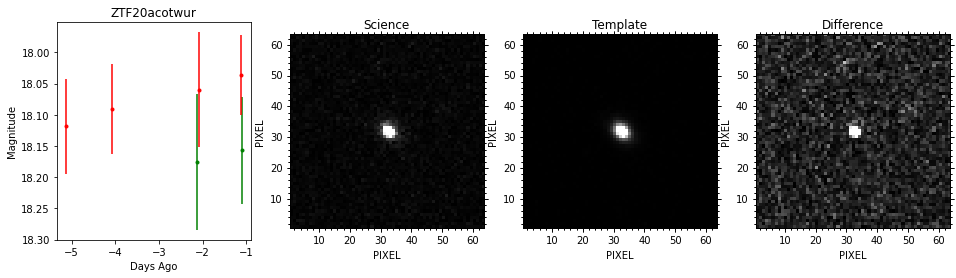

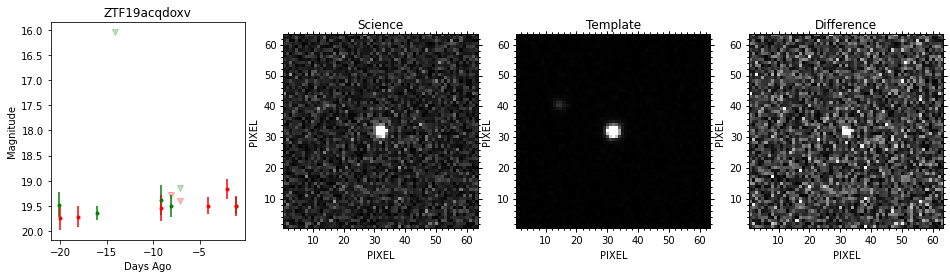

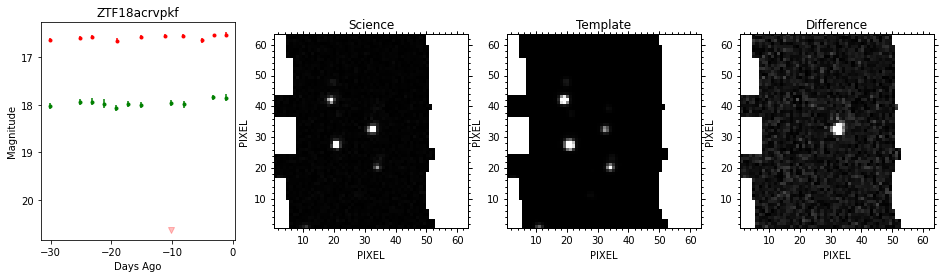

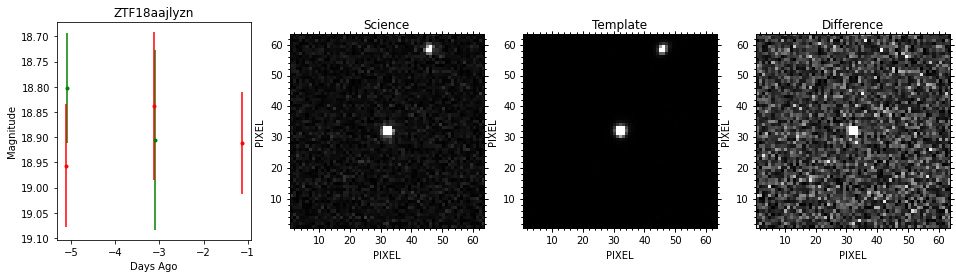

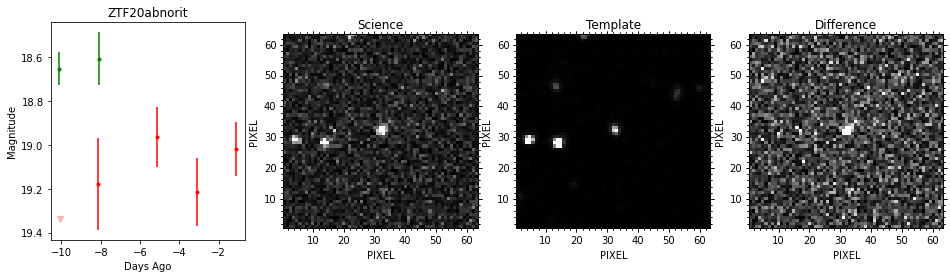

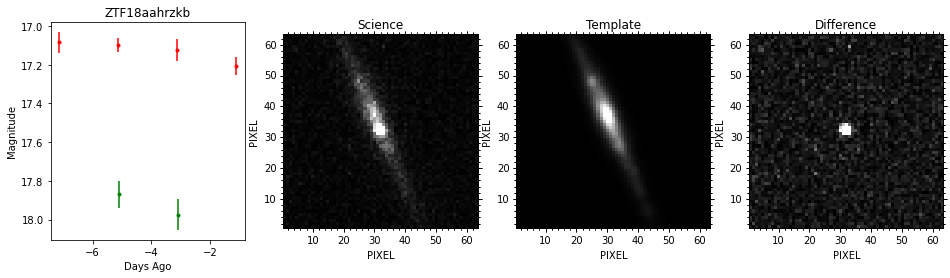

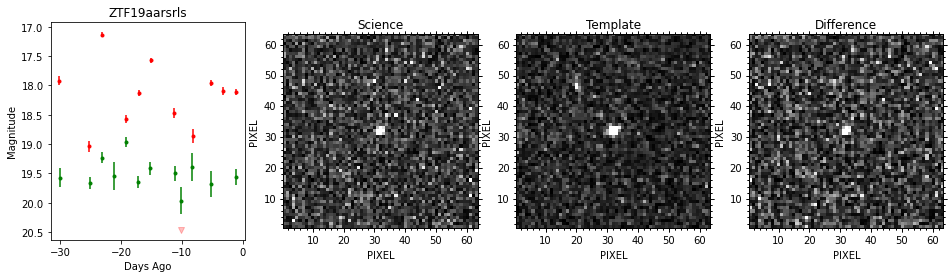

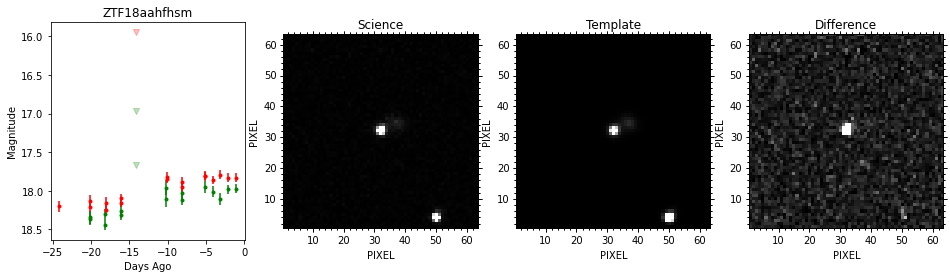

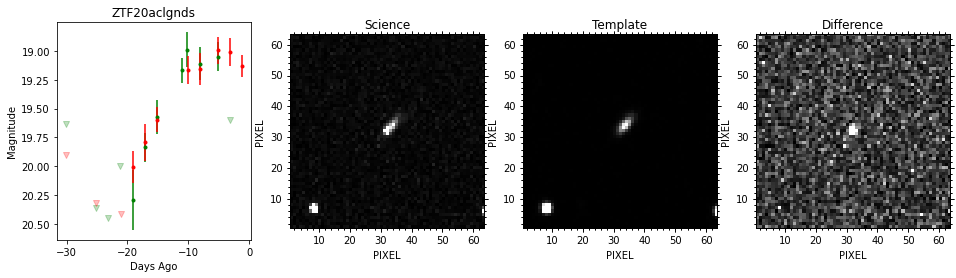

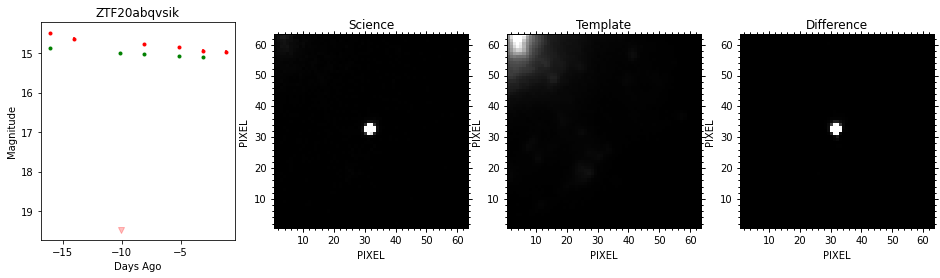

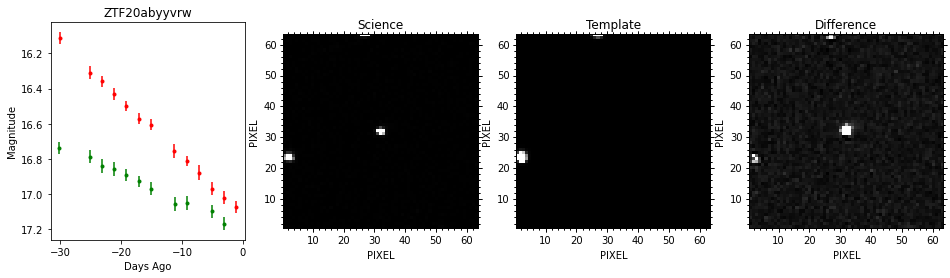

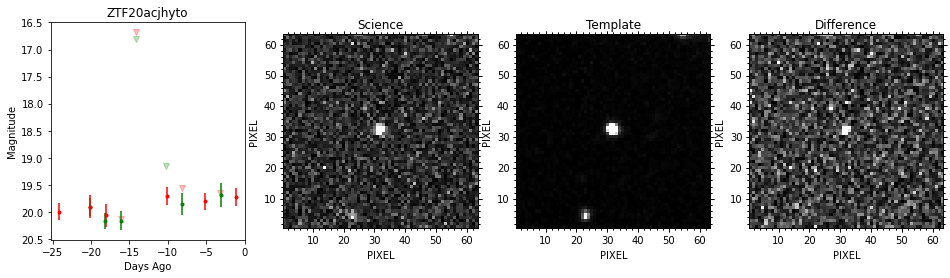

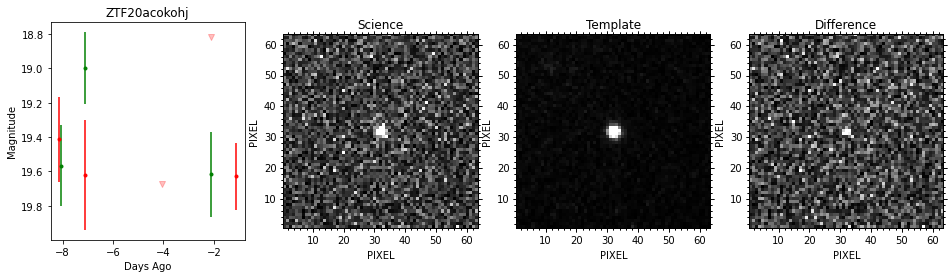

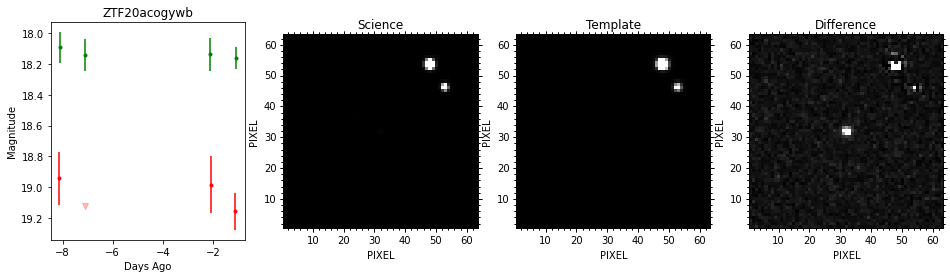

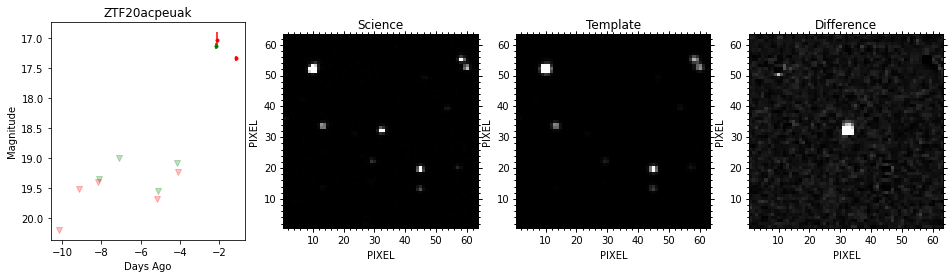

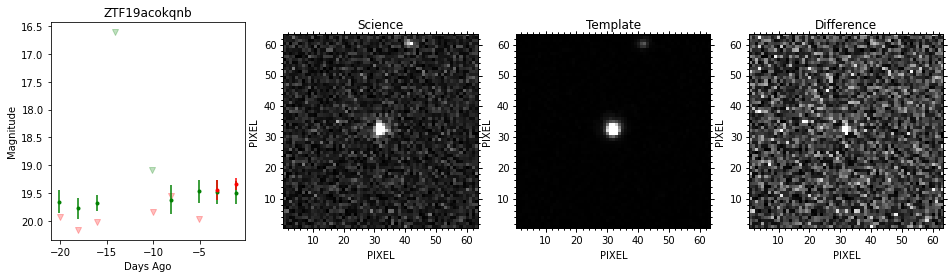

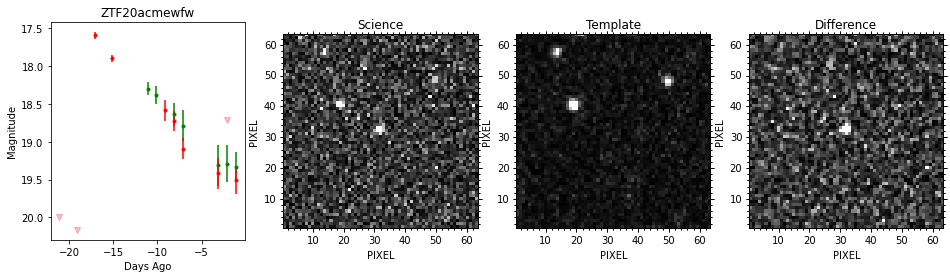

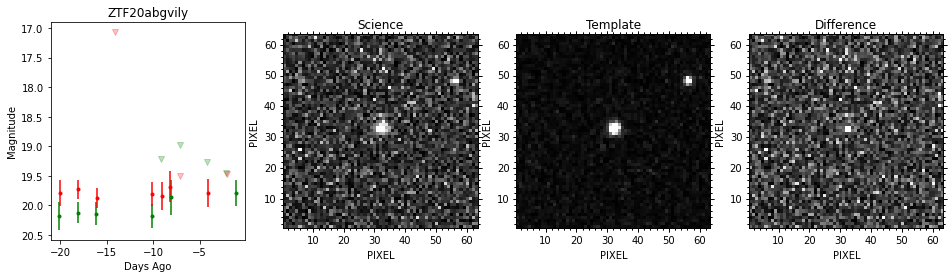

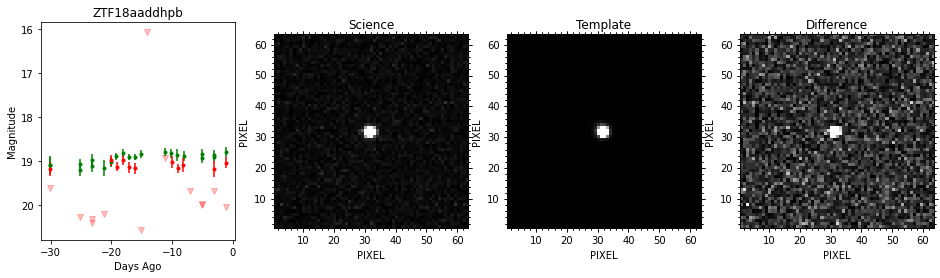

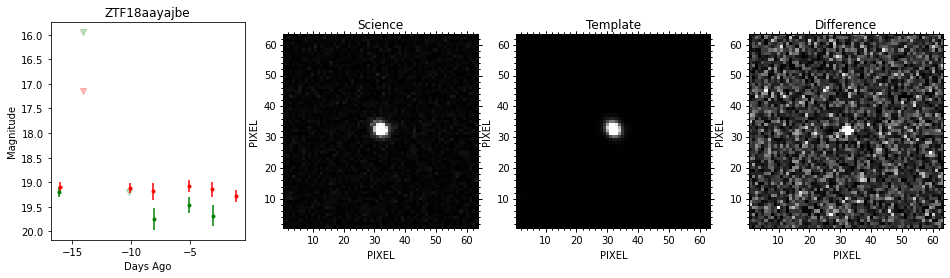

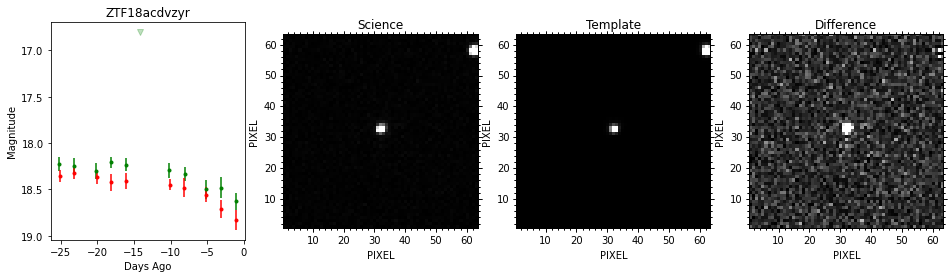

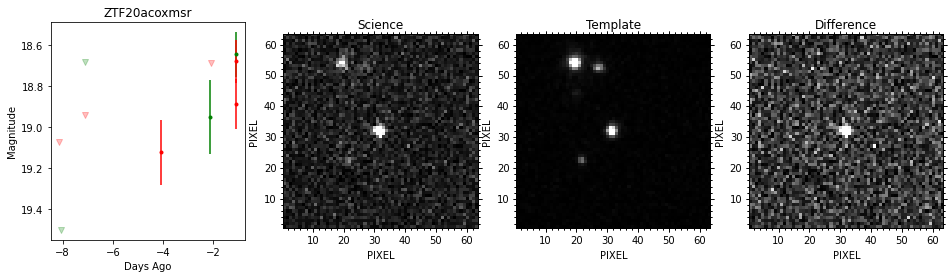

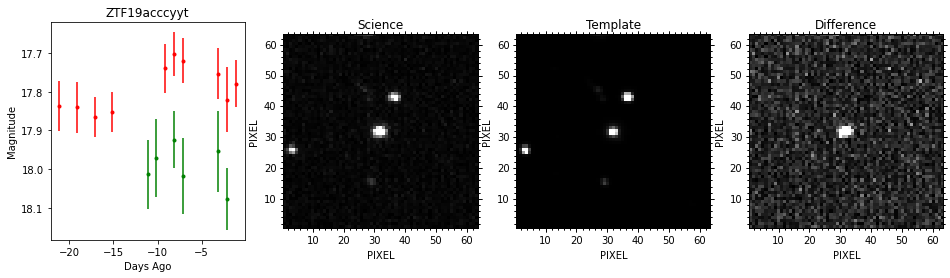

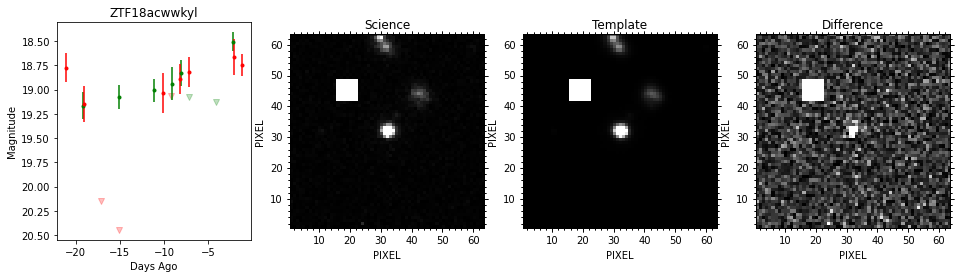

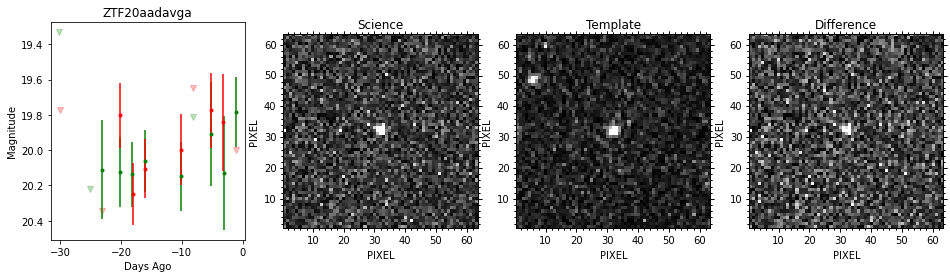

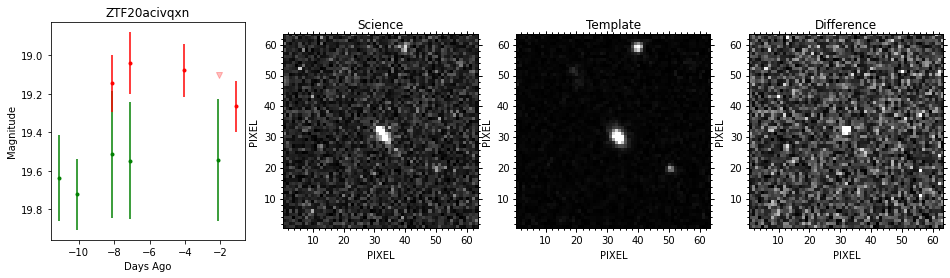

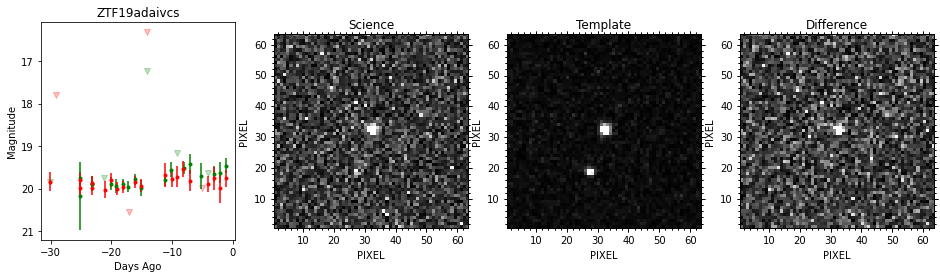

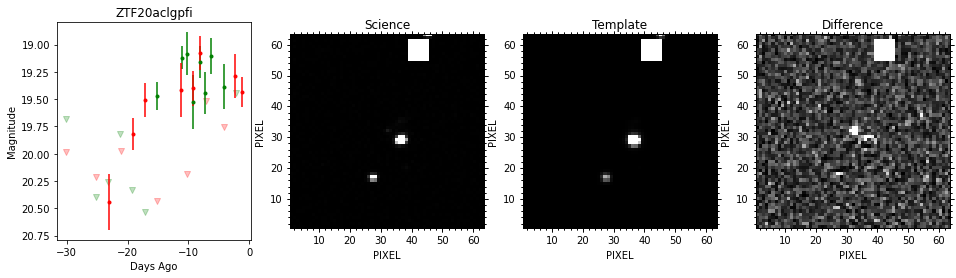

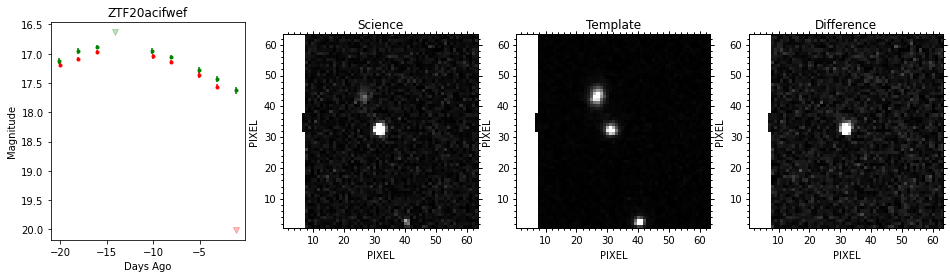

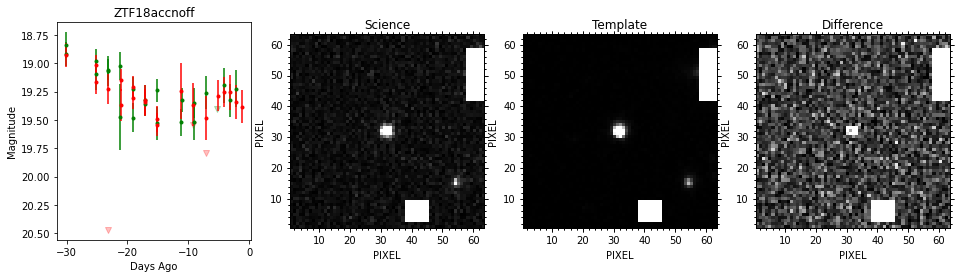

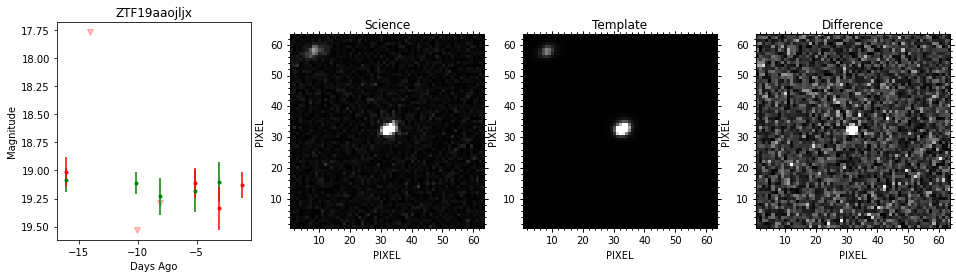

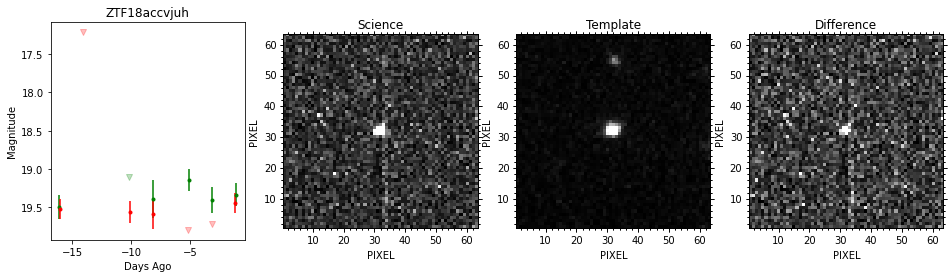

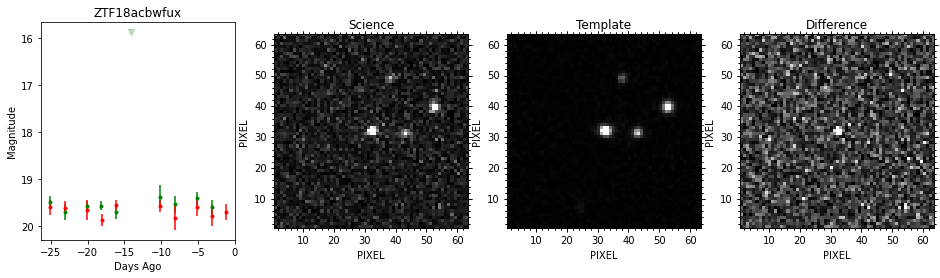

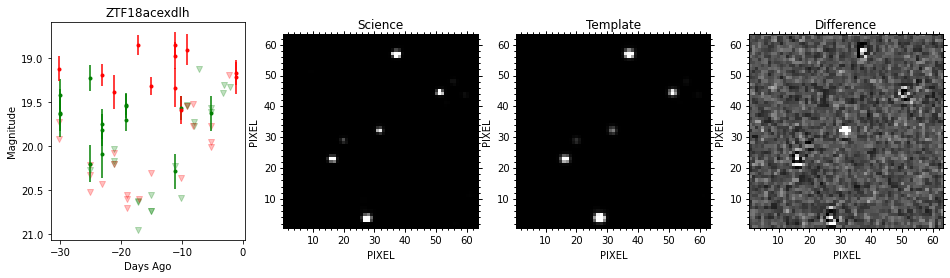

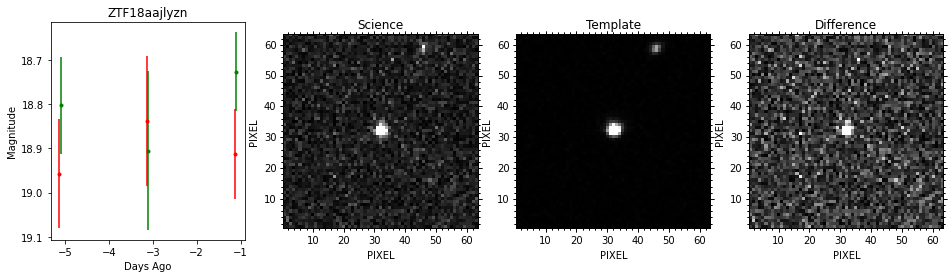

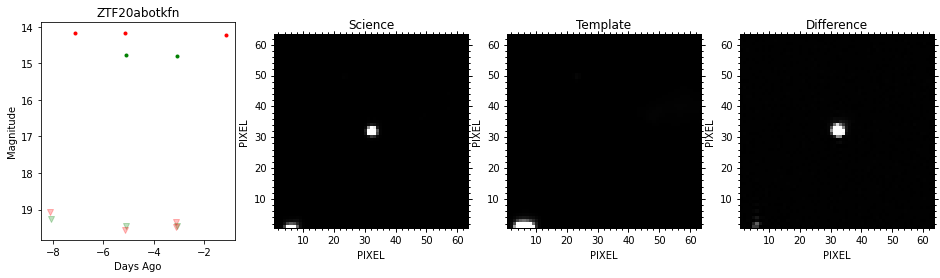

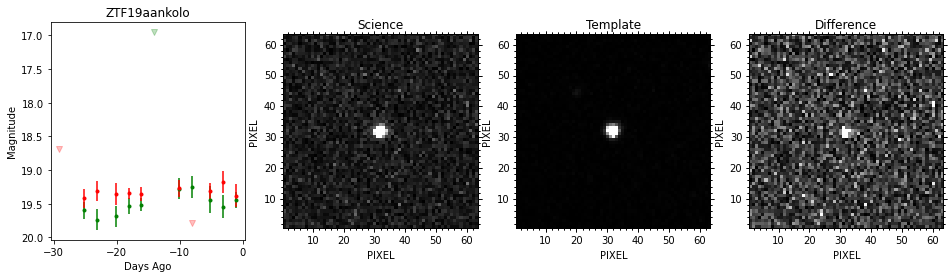

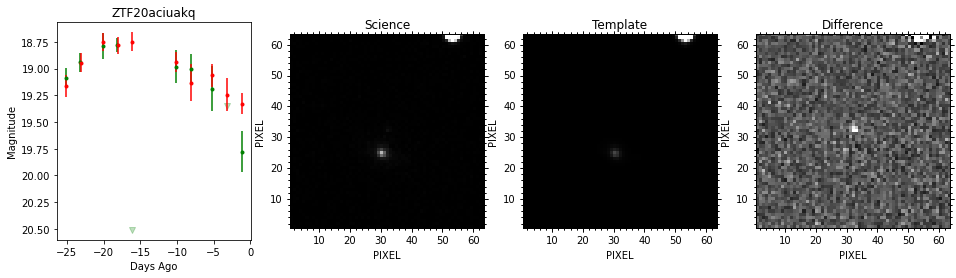

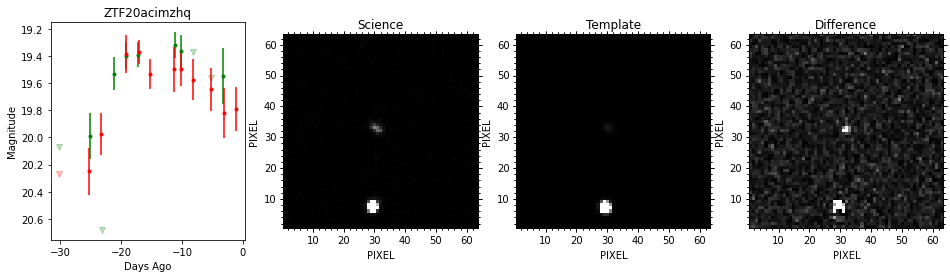

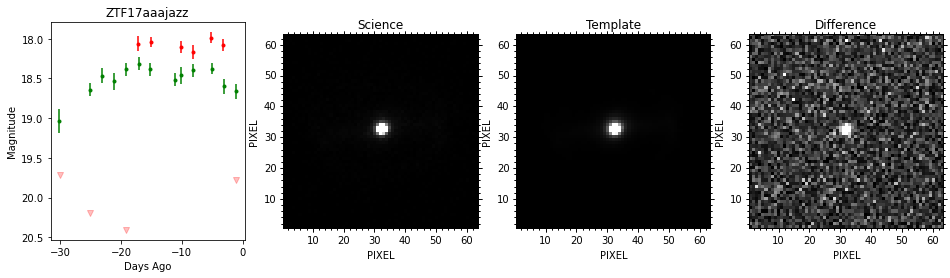

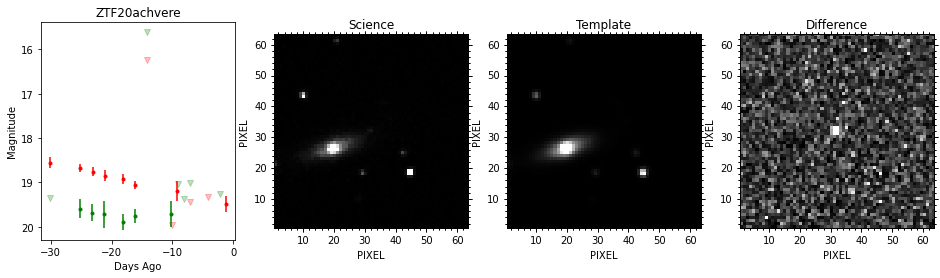

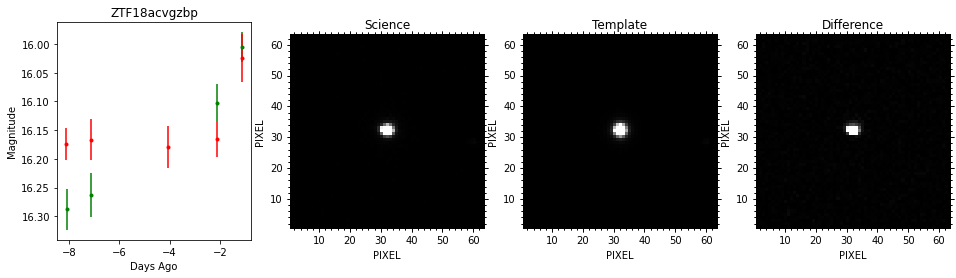

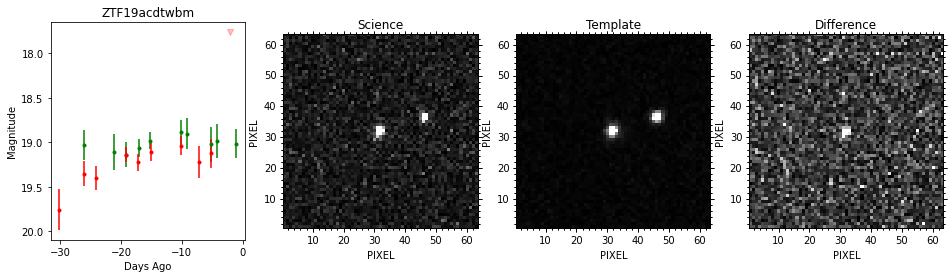

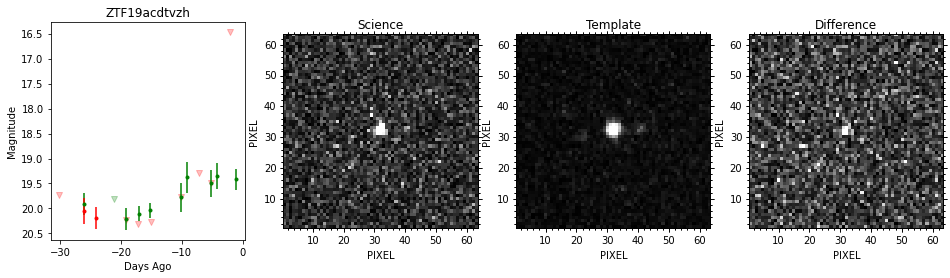

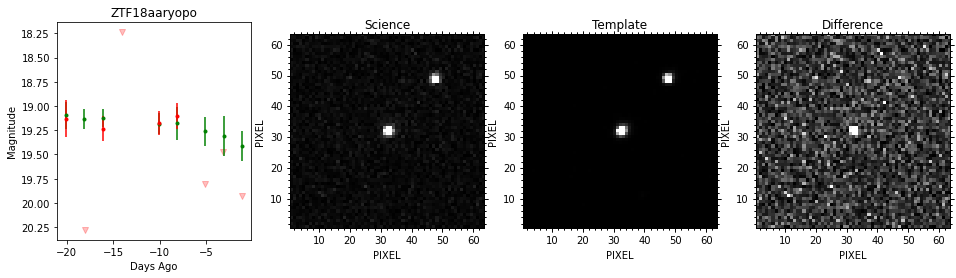

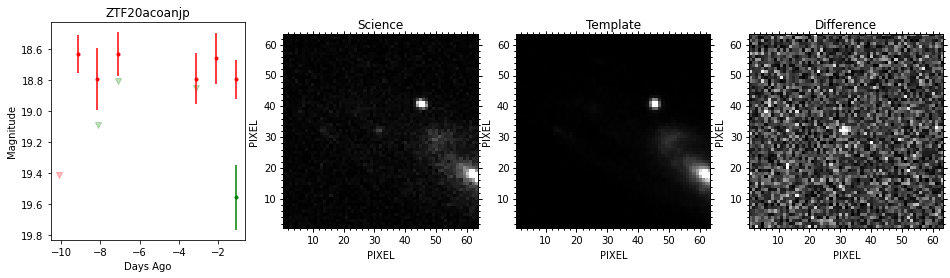

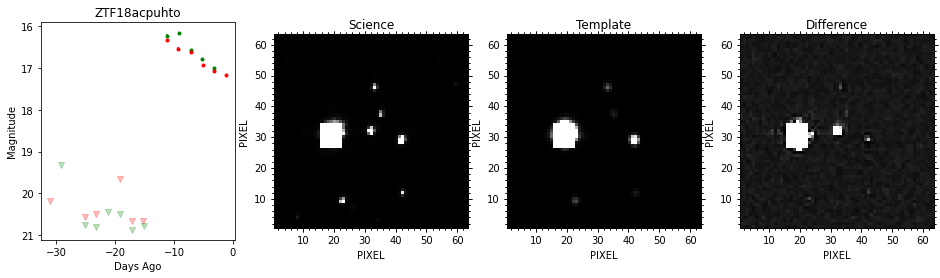

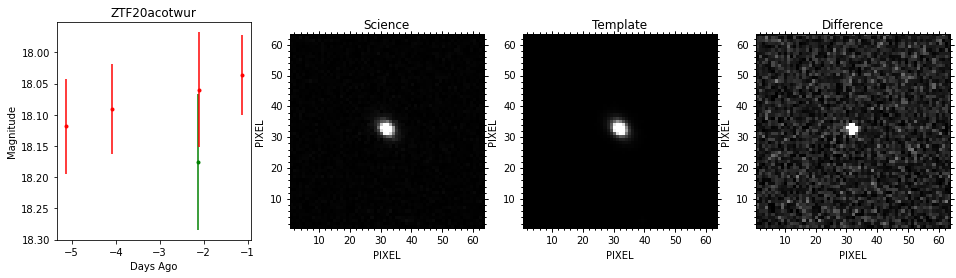

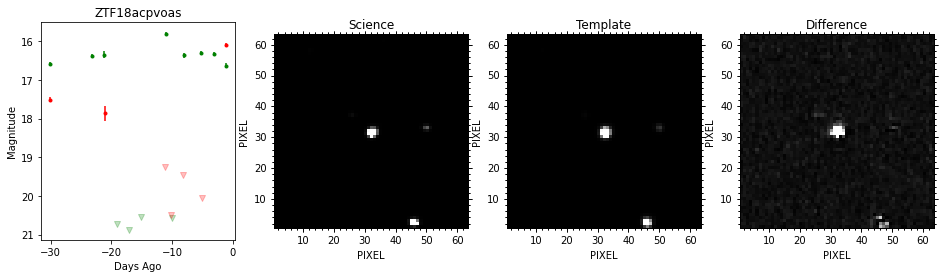

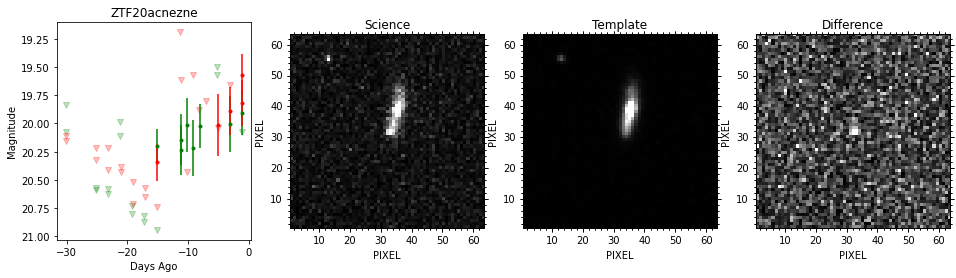

In [38]:
for packet in transient_alerts:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        show_all(packet)